In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Librerías para arboles de decision 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Librerias para regresión logística
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Librería para PCA
from sklearn.decomposition import PCA
# Libreria para KMeans
from sklearn.cluster import KMeans
# Libreria para normalizar
from sklearn.preprocessing import StandardScaler
# Libreria para separar en train y test
from sklearn.model_selection import train_test_split
# Librería para RandomForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# Librerías para métricas
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report,recall_score, f1_score
import scipy 
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)

In [5]:
# Función para calcular métricas
def CalculaMetricas(variable):
    
    # Elimino los vacíos
    variable = variable[variable.isnull() == False]

    media = variable.mean()
    mediana = variable.median()
    media_recortada = scipy.stats.trim_mean(variable,0.1)
    varianza = variable.var()
    desvio = variable.std()
    primer_cuartil = variable.quantile(0.25)
    tercer_cuartil = variable.quantile(0.75)
    percentil_1 = variable.quantile(0.01)
    percentil_99 = variable.quantile(0.99)
    error_estandar = scipy.stats.sem(variable) 
    cv = scipy.stats.variation(variable)
    asimetria = scipy.stats.skew(variable) 
    curtosis = scipy.stats.kurtosis(variable)    
    
    resultado = (
        f'Medidas de Tendencia Central\n'
        f'Media: {round(media, 0)}\n'
        f'Media Recortada: {round(media_recortada, 0)}\n'
        f'Mediana: {round(mediana, 0)}\n\n'
        f'Medidas de Localización\n'
        f'Primer Cuartil: {round(primer_cuartil, 0)}\n'
        f'Tercer Cuartil: {round(tercer_cuartil, 0)}\n'
        f'Percentil 1: {round(percentil_1, 0)}\n'
        f'Percentil 99: {round(percentil_99, 0)}\n\n'
        f'Medidas de Dispersión Absolutas\n'
        f'Varianza: {round(varianza, 0)}\n'
        f'Desvío Estándar: {round(desvio, 0)}\n'
        f'Rango Intercuartílico: {round(tercer_cuartil - primer_cuartil, 0)}\n'
        f'Error Estándar: {round(error_estandar, 0)}\n\n'
        f'Medidas de Dispersión Relativas\n'
        f'Coeficiente de Variación: {round(cv, 2)}\n'
        f'Desvío Intercuartílico: {round((tercer_cuartil - primer_cuartil) / (tercer_cuartil + primer_cuartil), 2)}\n\n'
        f'Medidas de Asimetría y Curtosis\n'
        f'Coeficiente de Asimetría: {round(asimetria, 2)}\n'
        f'Coeficiente de Curtosis: {round(curtosis, 2)}'
    )

    print(resultado)

In [2]:
# Importo la data
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/Titanic.csv'
df = pd.read_csv(url, sep = ',')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Descripción de campos
Variable  | Descripcion
-------------------|------------------
Survived|	Survived (1) or died (0)
Pclass	|Passenger’s class
Name	|Passenger’s name
Sex	|Passenger’s sex
Age	|Passenger’s age
SibSp	|Number of siblings/spouses aboard
Parch	|Number of parents/children aboard
Ticket	|Ticket number
Fare	|Fare
Cabin	|Cabin
Embarked	|Port of embarkation

# Preprocesamiento: Manejo de nulos 

In [6]:
nulos = df.isnull().sum()
nulos = nulos[nulos > 0]
cant = df.shape[0]
nulos = pd.DataFrame(nulos)
nulos['Pct'] = round(nulos / cant,2)
nulos.sort_values('Pct',ascending = False)

,0,Pct
Cabin,687,0.77
Age,177,0.20
Embarked,2,0.00


## Definiciones
1. **Cabin:** dado que más del 50% se encuentra vacío, se eliminará la columna para no utilizarla en el análisis. 
2. **Age:** Se imputarán los valores faltantes con alguna técnica.
3. **Embarked:** Se imputarán los valores faltantes con alguna técnica.

## 1. Cabin


In [7]:
df = df.drop(columns='Cabin')

## 2. Age
Crearemos un modelo que prediga las edades en función de otras variables. <br>
Usaremos el paquete 'IterativeImputer' de la librería 'fancyimpute'. Este es una clase que implementa un método de imputación iterativo. Este método se basa en la idea de que los valores faltantes pueden ser estimados con mayor precisión si se toma en cuenta la información de otros atributos en el conjunto de datos.

In [8]:
# Hay que imputar 177 casos
df['Age'].isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

### ¿Cómo arrancamos?
1. Estudiar a la variable de manera univariada 
2. Detectar con qué variables pareciera tener mayor relación 
3. Estudiar las relaciones y seleccionar features para el modelo de imputación

Text(0.5, 1.0, 'Distribución de Age')

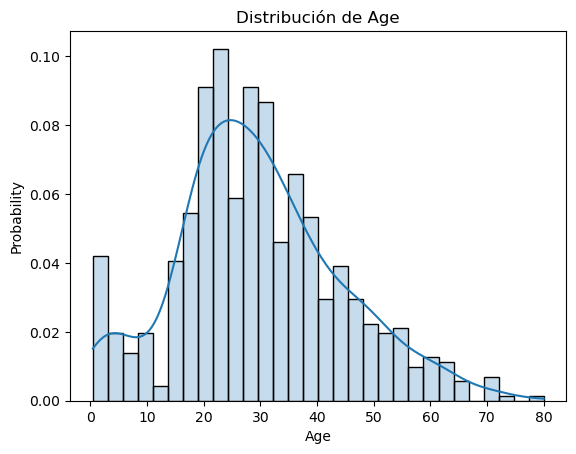

In [9]:
# Distribución de variable Edad
plt.figure()
# Histograma
sns.histplot(data = df,
             x = 'Age',
             bins = 30,            
             alpha = 0.25,
             kde = True,
             stat='probability')
plt.title('Distribución de Age')

In [10]:
# Métricas de la variable Age
CalculaMetricas(df['Age'])

Medidas de Tendencia Central
Media: 30.0
Media Recortada: 29.0
Mediana: 28.0

Medidas de Localización
Primer Cuartil: 20.0
Tercer Cuartil: 38.0
Percentil 1: 1.0
Percentil 99: 66.0

Medidas de Dispersión Absolutas
Varianza: 211.0
Desvío Estándar: 15.0
Rango Intercuartílico: 18.0
Error Estándar: 1.0

Medidas de Dispersión Relativas
Coeficiente de Variación: 0.49
Desvío Intercuartílico: 0.31

Medidas de Asimetría y Curtosis
Coeficiente de Asimetría: 0.39
Coeficiente de Curtosis: 0.17


In [11]:
# Genero algunos features extra
df['Is_Male'] = df['Sex'] == 'male'

# Filtro para quedarme con aquellos que no tienne NA en la variable de interes
df_analizar = df.loc[df['Age'].isnull() == False,]

# Declaro features a estudiar
features = ['Pclass','SibSp','Fare','Is_Male']

# Genero matriz de features y array de target
X = df_analizar[features].values
y = df_analizar['Age'].values

# Crear el modelo de Random Forest
model = RandomForestRegressor(n_estimators = 150, 
                               random_state = 123,
                               max_depth = 5,
                               min_samples_leaf = 100,
                               max_features = 3) 

# Entrenar el modelo
model.fit(X, y)

# Obtener la importancia de las características
feature_importance = model.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df.sort_values(by = 'Importance', ascending = False)

,Feature,Importance
0,Pclass,0.645240
2,Fare,0.201425
1,SibSp,0.147604
3,Is_Male,0.005731


Text(0.5, 1.0, 'Relación entre PClass y Age')

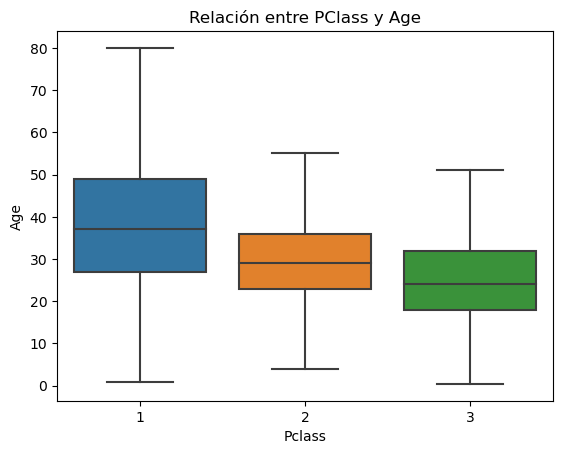

In [12]:
# Analizo relaciones
# PClass
plt.figure()
sns.boxplot(data = df_analizar,
            x = 'Pclass',
            y = 'Age', 
            showfliers = False)
plt.title('Relación entre PClass y Age')

Text(0.5, 1.0, 'Relación entre SibSp y Age')

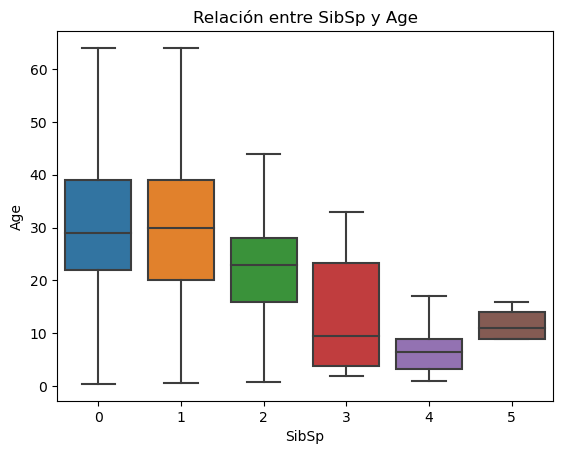

In [13]:
plt.figure()
sns.boxplot(data = df_analizar,
            x = 'SibSp',
            y = 'Age', 
            showfliers = False)
plt.title('Relación entre SibSp y Age')

C:\Users\usernosis\AppData\Local\Temp\ipykernel_14424\1858843438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analizar['SibSp_top'] = np.where(df_analizar['SibSp'] > 3,3,df_analizar['SibSp'])


Text(0.5, 1.0, 'Relación entre SibSp_top y Age')

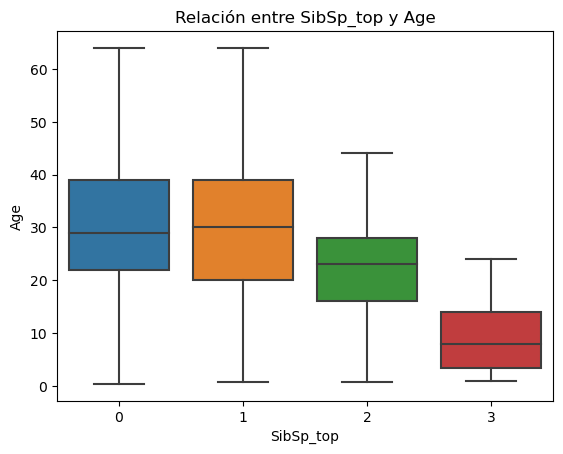

In [14]:
# La voy a topear en 3:
df_analizar['SibSp_top'] = np.where(df_analizar['SibSp'] > 3,3,df_analizar['SibSp'])
plt.figure()
sns.boxplot(data = df_analizar,
            x = 'SibSp_top',
            y = 'Age', 
            showfliers = False)
plt.title('Relación entre SibSp_top y Age')

C:\Users\usernosis\AppData\Local\Temp\ipykernel_14424\1550340897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analizar['Fare_log'] = np.log(df_analizar['Fare'] + 1)


Text(0.5, 1.0, 'Relación entre Fare y Age - Correlación: 0.116')

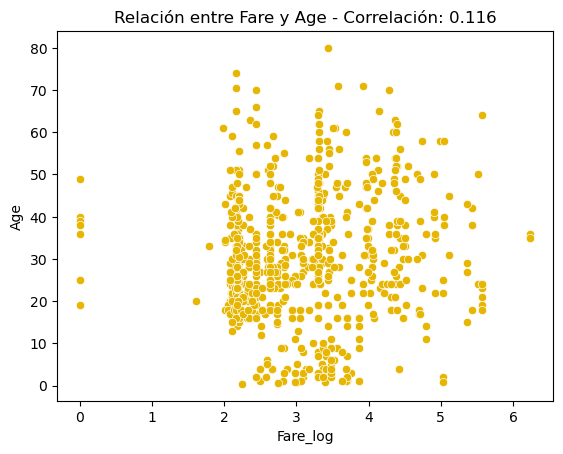

In [15]:
# Fare
df_analizar['Fare_log'] = np.log(df_analizar['Fare'] + 1)
sns.scatterplot(data = df_analizar,
                x = 'Fare_log',
                y = 'Age',
                color = '#E7B602')
coeficiente = round(df_analizar[['Age','Fare_log']].corr(method='pearson').iloc[0,1],3)
plt.title('Relación entre Fare y Age - Correlación: ' + str(coeficiente))

Text(0.5, 1.0, 'Relación entre Sex y Age')

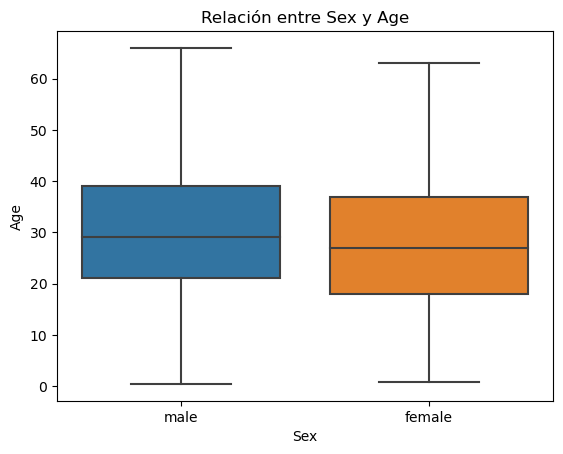

In [16]:
plt.figure()
sns.boxplot(data = df_analizar,
            x = 'Sex',
            y = 'Age', 
            showfliers = False)
plt.title('Relación entre Sex y Age')
# No hay diferencia, no la usamos

In [17]:
# Abro librería
from fancyimpute import IterativeImputer

# Genero features nuevas
df['Fare_log'] = np.log(df['Fare'] + 1)
df['SibSp_top'] = np.where(df['SibSp'] > 3,3,df['SibSp'])

features_age = ['Age','Pclass','SibSp_top','Fare_log']

# Genero el imputador
imputador_age = IterativeImputer(max_iter = 20,
                                 random_state = 123)

# Lo entreno
imputador_age.fit(df[features_age])

# Lo aplico
data_imputada = pd.DataFrame(imputador_age.transform(df[features_age]))

# Asigno nombres de columnas
data_imputada.columns = features_age

In [18]:
data_imputada.head()

,Age,Pclass,SibSp_top,Fare_log
0,22.0,3.0,1.0,2.110213
1,38.0,1.0,1.0,4.280593
2,26.0,3.0,0.0,2.188856
3,35.0,1.0,1.0,3.990834
4,35.0,3.0,0.0,2.202765


In [19]:
# Reasigno 
df['Age_Imp'] = data_imputada['Age']

In [20]:
df['Age_Imp'].isnull().sum()

0

In [21]:
df['Age'].isnull().sum()

177

Text(0.5, 1.0, 'Modificacion MICE Age')

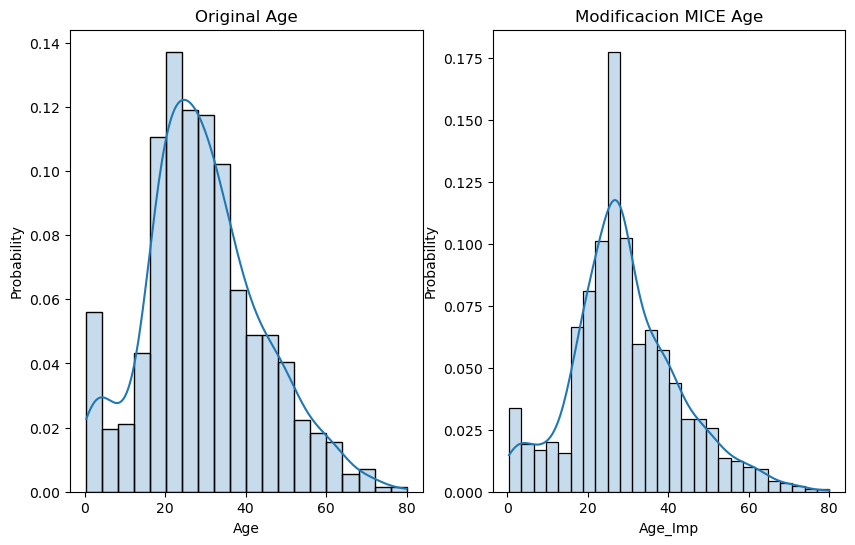

In [22]:
# Gráfico comparativo
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(df['Age'],                    
             alpha = 0.25,
             kde = True,
             stat='probability')
plt.title('Original Age')
plt.subplot(122)
sns.histplot(df['Age_Imp'],                    
             alpha = 0.25,
             kde = True,
             stat='probability')
plt.title('Modificacion MICE Age')

In [26]:
(df['Age_Imp'][df['Age_Isnull'] == 1]).value_counts().sort_values()

35.232804     1
26.291243     1
21.293770     1
27.501352     1
40.249698     1
             ..
27.630616     7
10.552216     7
27.443388    14
27.477231    15
27.509774    19
Name: Age_Imp, Length: 81, dtype: int64

## Revisemos: Dónde estaban los vacíos? 

In [23]:
df['Age_Isnull'] = np.where(df['Age'].isnull() == True,1,0)

Text(0, 0.5, 'Cantidad de pasajeros')

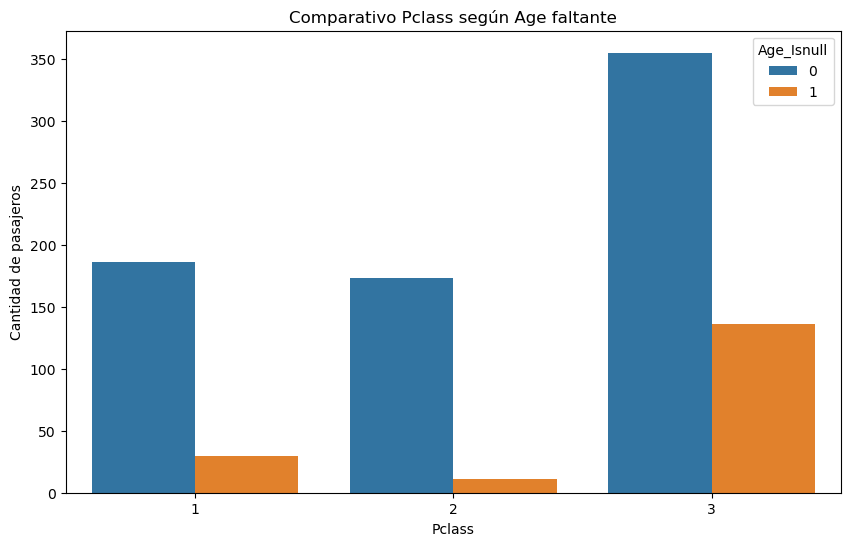

In [24]:
plt.figure(figsize=(10,6)) 
sns.countplot(x = "Pclass", 
            hue = "Age_Isnull", 
            data = df)
plt.title('Comparativo Pclass según Age faltante')
plt.ylabel("Cantidad de pasajeros")

## 3. Embarked
Imputaremos con la categoría más frecuente de acuerdo al precio que pagó por su ticket. <br>
Esto lo haremos así dado que sólo dos registros del total del dataset tiene información faltante. Para no perder el registro, asignamos con el valor más frecuente. 

In [27]:
df['Embarked'].isnull().sum()

2

Text(0, 0.5, 'Cantidad de pasajeros')

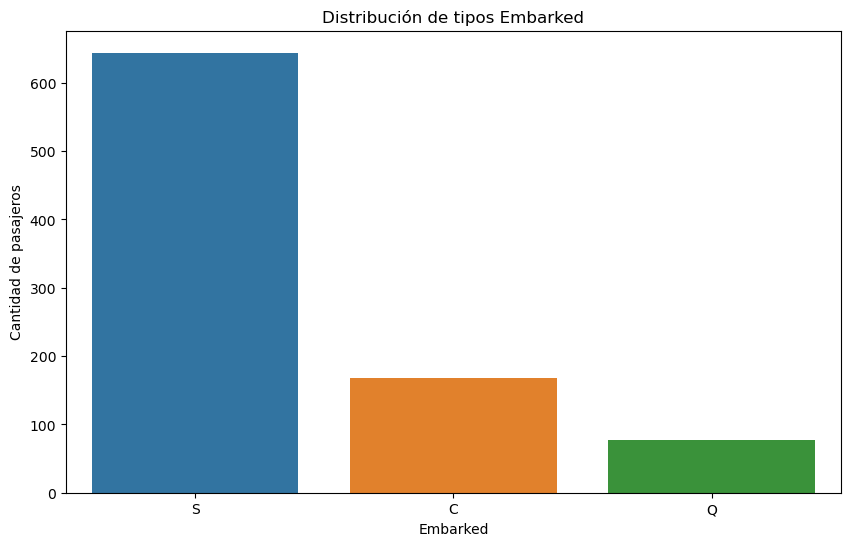

In [28]:
plt.figure(figsize=(10,6)) 
sns.countplot(x = "Embarked", 
            data = df)
plt.title('Distribución de tipos Embarked')
plt.ylabel("Cantidad de pasajeros")

Text(0.5, 1.0, 'Relación entre Fare y Embarked')

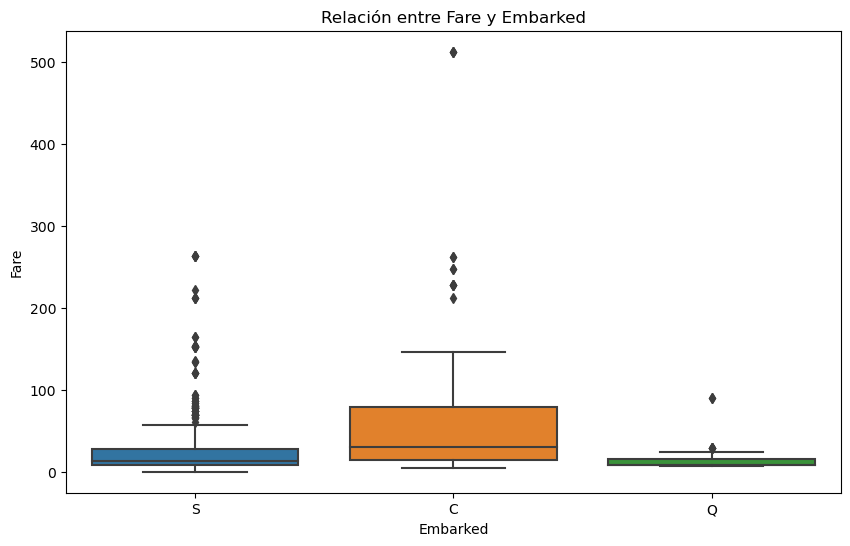

In [29]:
plt.figure(figsize=(10,6)) 
sns.boxplot(y = 'Fare', 
              x = 'Embarked',
            data = df)
plt.title('Relación entre Fare y Embarked')

In [30]:
resultados = df.groupby('Embarked').agg(           
    Mediana = ('Fare', 'median'),            
    Media = ('Fare', 'mean')
).reset_index()
resultados

,Embarked,Mediana,Media
0,C,29.70,59.954144
1,Q,7.75,13.276030
2,S,13.00,27.079812


In [31]:
# Regla propuesta 
df['Fare_Group'] = np.where(df['Fare'] <= 8,"Q",
                           np.where(df['Fare'] > 30, "C","S"))
df['Es_Q'] = np.where(df['Embarked'] == "Q", 1, 0)
df['Es_C'] = np.where(df['Embarked'] == "C", 1, 0)
df['Es_S'] = np.where(df['Embarked'] == "S", 1, 0)
resultados = df.groupby('Fare_Group').agg(           
    Pct_Q = ('Es_Q', 'mean'),            
    Pct_C = ('Es_C', 'mean'),      
    Pct_S = ('Es_S', 'mean') 
).reset_index()
resultados

,Fare_Group,Pct_Q,Pct_C,Pct_S
0,C,0.008547,0.346154,0.636752
1,Q,0.211618,0.141079,0.647303
2,S,0.057692,0.127404,0.814904


In [32]:
# Y cómo es el Fare de el pasajero que tiene embarked vacío? 
df.loc[df['Embarked'].isnull(),]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Is_Male,Fare_log,SibSp_top,Age_Imp,Age_Isnull,Fare_Group,Es_Q,Es_C,Es_S
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,False,4.394449,0,38.0,0,C,0,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,False,4.394449,0,62.0,0,C,0,0,0


In [33]:
# Imputador propuesto:
def imputador_embarked(Embarked, Fare):
    if not pd.isnull(Embarked):
        return Embarked
    elif (pd.isnull(Embarked) and Fare <= 8):
        return "Q"
    elif (pd.isnull(Embarked) and Fare > 30):
        return "C"
    else:
        return "S"


In [34]:
# Aplico el imputador
df['Embarked_Imp'] =  df.apply(lambda row: imputador_embarked(row['Embarked'], row['Fare']), 
                                 axis = 1)

In [35]:
# Verifiquemos qué pasó
df.loc[df['Embarked'].isnull(),['PassengerId','Fare','Embarked','Embarked_Imp']]

,PassengerId,Fare,Embarked,Embarked_Imp
61,62,80.0,NaN,C
829,830,80.0,NaN,C


In [36]:
# Y el resto quedó igual?
df.loc[df['Embarked'].isnull() == False,['PassengerId','Fare','Embarked','Embarked_Imp']].head()

,PassengerId,Fare,Embarked,Embarked_Imp
0,1,7.2500,S,S
1,2,71.2833,C,C
2,3,7.9250,S,S
3,4,53.1000,S,S
4,5,8.0500,S,S


# Feature Engineering

In [37]:
# Exploraremos la columna passenger name y nos interesa la abreviatura de cada uno
import re
df['Title'] = df['Name'].apply(lambda x : re.sub("(.*, )|(\\..*)", "", x)) 
df.loc[:,['PassengerId','Name','Title']].head()

,PassengerId,Name,Title
0,1,"Braund, Mr. Owen Harris",Mr
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,3,"Heikkinen, Miss. Laina",Miss
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,5,"Allen, Mr. William Henry",Mr


In [38]:
pd.crosstab(df['Sex'], df['Title'])

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [39]:
rare_title = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
df.loc[df.Title == 'Mlle','Title'] ='Miss'
df.loc[df.Title == 'Ms','Title'] ='Miss'
df.loc[df.Title == 'Mme','Title'] ='Mrs'
df.loc[df.Title.isin(rare_title),'Title'] ='Rare Title'
pd.crosstab(df.Sex, df.Title)

Title,Master,Miss,Mr,Mrs,Rare Title
Sex,,,,,
female,0,185,0,126,3
male,40,0,517,0,20


In [40]:
# Extrayendo el apellido
df['Surname'] = df['Name'].apply(lambda x : x[:x.index(',')])
df.loc[:,['PassengerId','Name','Surname']].head()

,PassengerId,Name,Surname
0,1,"Braund, Mr. Owen Harris",Braund
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings
2,3,"Heikkinen, Miss. Laina",Heikkinen
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle
4,5,"Allen, Mr. William Henry",Allen


In [41]:
# Tamaño de la familia 
df['Fsize'] = df['SibSp'] + df['Parch'] + 1
df['Fsize'] = df['Fsize'].astype('str')
df['Family'] = df[['Surname', 'Fsize']].agg('_'.join, axis=1)
df.loc[:,['PassengerId','Name','Surname','Fsize','Family']].head()

,PassengerId,Name,Surname,Fsize,Family
0,1,"Braund, Mr. Owen Harris",Braund,2,Braund_2
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,2,Cumings_2
2,3,"Heikkinen, Miss. Laina",Heikkinen,1,Heikkinen_1
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,2,Futrelle_2
4,5,"Allen, Mr. William Henry",Allen,1,Allen_1


In [42]:
# Creando la variable Mother
df['Mother'] = np.where((df['Sex'] == 'female') & 
                        (df['Parch'] > 0) & 
                        (df['Title'] != 'Miss'),1,0)
df['Mother'].value_counts()

0    835
1     56
Name: Mother, dtype: int64

In [43]:
# Discretizar la variable family size
df['Fsize'] = df['Fsize'].astype('int')
df['FsizeD'] = np.where(df.Fsize ==1, 'singleton',
                        np.where(((df.Fsize <5) & (df.Fsize >1)),'small','large'))
df.loc[:,['PassengerId','Name','Surname','Fsize','Family','FsizeD']].head()

,PassengerId,Name,Surname,Fsize,Family,FsizeD
0,1,"Braund, Mr. Owen Harris",Braund,2,Braund_2,small
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,2,Cumings_2,small
2,3,"Heikkinen, Miss. Laina",Heikkinen,1,Heikkinen_1,singleton
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,2,Futrelle_2,small
4,5,"Allen, Mr. William Henry",Allen,1,Allen_1,singleton


In [44]:
df['FsizeD'].value_counts()

singleton    537
small        292
large         62
Name: FsizeD, dtype: int64

In [45]:
# Encoding
df['Es_Q'] = np.where(df['Embarked_Imp'] == "Q", 1, 0)
df['Es_C'] = np.where(df['Embarked_Imp'] == "C", 1, 0)
df['Es_S'] = np.where(df['Embarked_Imp'] == "S", 1, 0)
df['Es_Master'] = np.where(df['Title'] == "Master", 1, 0)
df['Es_Miss'] = np.where(df['Title'] == "Miss", 1, 0)
df['Es_Mr'] = np.where(df['Title'] == "Mr", 1, 0)
df['Es_Mrs'] = np.where(df['Title'] == "Mrs", 1, 0)
df['Es_singleton'] = np.where(df['FsizeD'] == "singleton", 1, 0)
df['Es_small'] = np.where(df['FsizeD'] == "small", 1, 0)
df['Es_Pclass_1'] = np.where(df['Pclass'] == 1, 1, 0)
df['Es_Pclass_3'] = np.where(df['Pclass'] == 3, 1, 0)
df['Tiene_Parch'] = np.where(df['Parch'] > 0, 1, 0)

# Transformations
df['Age_log'] = np.log(df['Age_Imp'] + 1)
df['Fare_log'] = np.log(np.where(df['Fare'] > df['Fare'].quantile(0.99),
                                 df['Fare'].quantile(0.99),
                                 df['Fare'])+ 1)

# Importancia de las variables

In [46]:
features = ['Pclass','Parch','Fare','Age_Imp','Is_Male','Fare_log',
           'SibSp_top','Es_Q', 'Es_C', 'Es_S', 'Mother',
       'Es_Master', 'Es_Miss','Es_Mr','Es_Mrs','Es_singleton','Es_small','Fsize','Age_log',
           'Es_Pclass_1','Es_Pclass_3','Tiene_Parch']

X = df[features].values
y = df['Survived'].values

# Crear el modelo de Random Forest
model = RandomForestClassifier(n_estimators = 150, 
                               random_state = 123,
                               max_depth = 7,
                               min_samples_leaf = 100,
                               max_features = 4,
                               criterion = 'entropy') 

# Entrenar el modelo
model.fit(X, y)

# Obtener la importancia de las características
feature_importance = model.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df.sort_values(by = 'Importance', ascending = False)

,Feature,Importance
4,Is_Male,0.265093
13,Es_Mr,0.172502
2,Fare,0.096863
5,Fare_log,0.094078
0,Pclass,0.080303
20,Es_Pclass_3,0.072047
12,Es_Miss,0.070461
16,Es_small,0.043497
19,Es_Pclass_1,0.033992
17,Fsize,0.027913


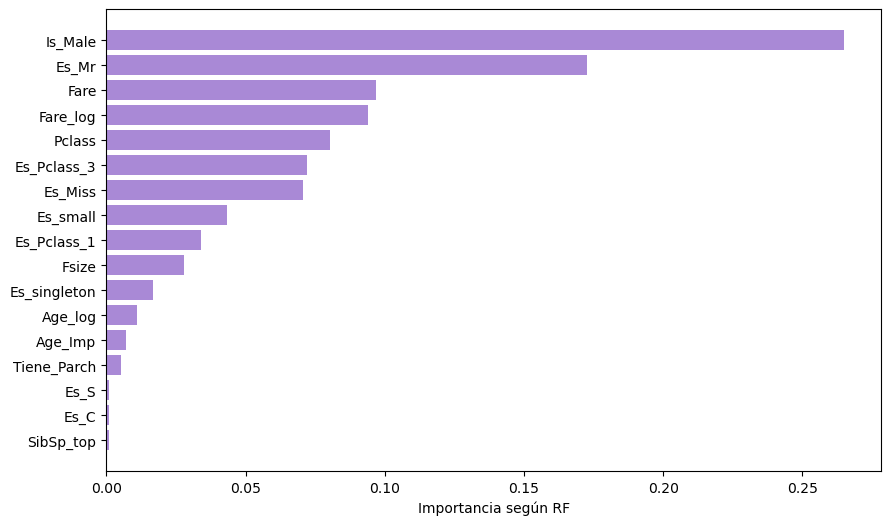

In [47]:
# Grafico la importancia de cada variable
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
importance_df = importance_df.loc[importance_df['Importance'] > 0,]
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(importance_df['Feature'], 
         importance_df['Importance'],
         color = '#A989D6')
plt.xlabel('Importancia según RF')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más relevante en la parte superior
plt.show() 

# Separo Train y Test

In [48]:
df_train,df_test = train_test_split(df,
                                    test_size = 0.25, #Porcentaje de muestra test 
                                    random_state = 44) #Semilla

In [49]:
# Check tasas similares 
print('Tasa Supervivencia TRAIN:')
print(round(df_train['Survived'].mean(),2))
print('Tasa Supervivencia TEST:')
print(round(df_test['Survived'].mean(),2))

Tasa Supervivencia TRAIN:
0.38
Tasa Supervivencia TEST:
0.38


# Modelo 1: Regresión Logística

In [50]:
from sklearn.linear_model import LogisticRegression

# Selecciono features y genero inputs del modelo
features = ['Es_Mr','Is_Male','Fare_log','Es_Pclass_1','Es_Pclass_3','Es_small',
           'Es_Miss','Es_singleton','Es_C','Es_S','Tiene_Parch']
X_train = df_train[features].values
y_train = df_train['Survived'].values
X_test = df_test[features].values
y_test = df_test['Survived'].values

# Genero y entreno
reg_log_1 = LogisticRegression()
reg_log_1.fit(X_train, y_train)

# Predicciones
y_pred_train = reg_log_1.predict(X_train)
y_pred_test = reg_log_1.predict(X_test)
y_pred_prob_train = reg_log_1.predict_proba(X_train)[:,1]
y_pred_prob_test = reg_log_1.predict_proba(X_test)[:,1]

Text(0.5, 1.0, 'Distribución Estimaciones TEST')

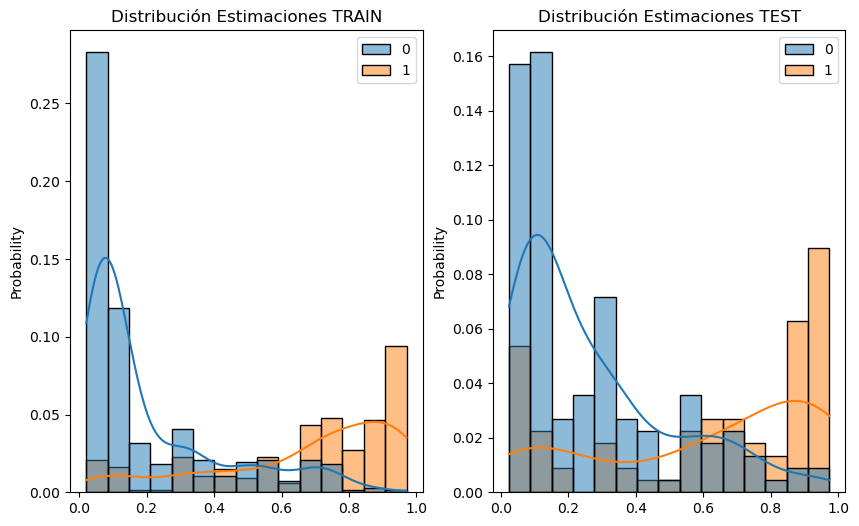

In [51]:
# Histogramas de predicción 
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(x = y_pred_prob_train,  
             alpha = 0.5,
             hue = y_train,
             stat = 'probability', 
             bins = 15,
            kde = True)
plt.title('Distribución Estimaciones TRAIN')
plt.subplot(122)
sns.histplot(x = y_pred_prob_test,  
             alpha = 0.5,
             hue = y_test,
             stat = 'probability', 
             bins = 15,
            kde = True)
plt.title('Distribución Estimaciones TEST')

In [53]:
# Poder de ordenamiento
# Agrego predicción en mi dataframes
df_train['Predict_Prob_RegLog'] = y_pred_prob_train
df_test['Predict_Prob_RegLog'] = y_pred_prob_test

# Defino cortes
bin_edges = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = range(1, 6)

# Corto
df_train['Predict_RegLog_Bin'] = pd.cut(df_train['Predict_Prob_RegLog'], 
                                  bins=bin_edges, 
                                  labels=bin_labels, 
                                  include_lowest=True)
df_test['Predict_RegLog_Bin'] = pd.cut(df_test['Predict_Prob_RegLog'], 
                                  bins=bin_edges, 
                                  labels=bin_labels, 
                                  include_lowest=True)

# Genero agrupaciones
resultados_nodo_TRAIN = df_train.groupby('Predict_RegLog_Bin').agg(     
    Cant = ('Predict_RegLog_Bin', 'count'),              
    Cant_Sup = ('Survived', 'sum'),            
    Tasa_Sup = ('Survived', 'mean')    
).reset_index()

resultados_nodo_TEST = df_test.groupby('Predict_RegLog_Bin').agg(     
    Cant = ('Predict_RegLog_Bin', 'count'),              
    Cant_Sup = ('Survived', 'sum'),            
    Tasa_Sup = ('Survived', 'mean')    
).reset_index()


In [54]:
resultados_nodo_TRAIN

,Predict_RegLog_Bin,Cant,Cant_Sup,Tasa_Sup
0,1,315,26,0.082540
1,2,76,23,0.302632
2,3,66,32,0.484848
3,4,101,70,0.693069
4,5,110,106,0.963636


In [55]:
resultados_nodo_TEST

,Predict_RegLog_Bin,Cant,Cant_Sup,Tasa_Sup
0,1,95,18,0.189474
1,2,37,7,0.189189
2,3,21,7,0.333333
3,4,28,16,0.571429
4,5,42,37,0.880952


Text(0.5, 1.0, 'Poder de Ordenamiento - TEST')

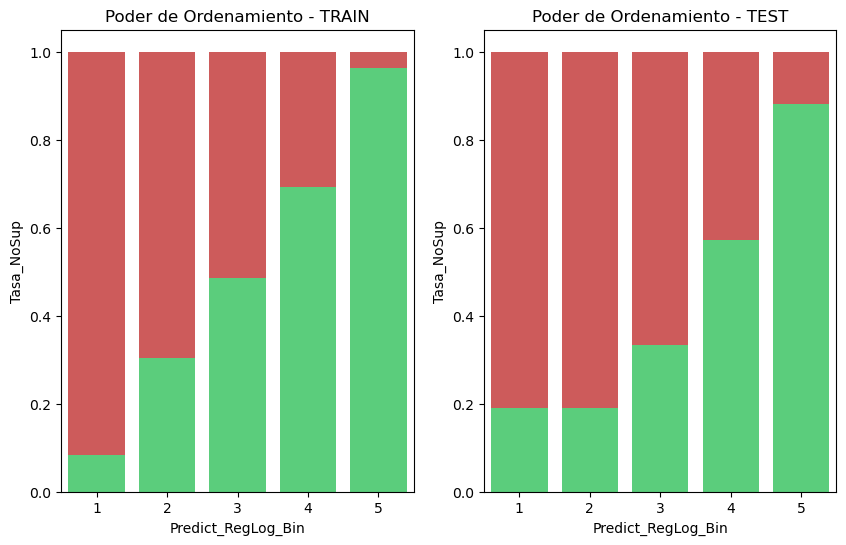

In [56]:
# Barplot por nodo 
resultados_nodo_TRAIN['Tasa_NoSup'] = (1 - resultados_nodo_TRAIN['Tasa_Sup'])
resultados_nodo_TEST['Tasa_NoSup'] = (1 - resultados_nodo_TEST['Tasa_Sup'])
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.barplot(data = resultados_nodo_TRAIN,
            x = 'Predict_RegLog_Bin',
            y = 'Tasa_Sup', 
            label = 'Porcentaje Supervivencia',
            color = '#48E074')
sns.barplot(data=resultados_nodo_TRAIN, 
            x = 'Predict_RegLog_Bin', 
            y = 'Tasa_NoSup', 
            bottom=resultados_nodo_TRAIN['Tasa_Sup'], 
            label = 'Porcentaje No Supervivencia',
            color = '#E04848')
plt.title('Poder de Ordenamiento - TRAIN')
plt.subplot(122)
sns.barplot(data = resultados_nodo_TEST,
            x = 'Predict_RegLog_Bin',
            y = 'Tasa_Sup', 
            label = 'Porcentaje Supervivencia',
            color = '#48E074')
sns.barplot(data=resultados_nodo_TEST, 
            x = 'Predict_RegLog_Bin', 
            y = 'Tasa_NoSup', 
            bottom=resultados_nodo_TEST['Tasa_Sup'], 
            label = 'Porcentaje No Supervivencia',
            color = '#E04848')
plt.title('Poder de Ordenamiento - TEST')

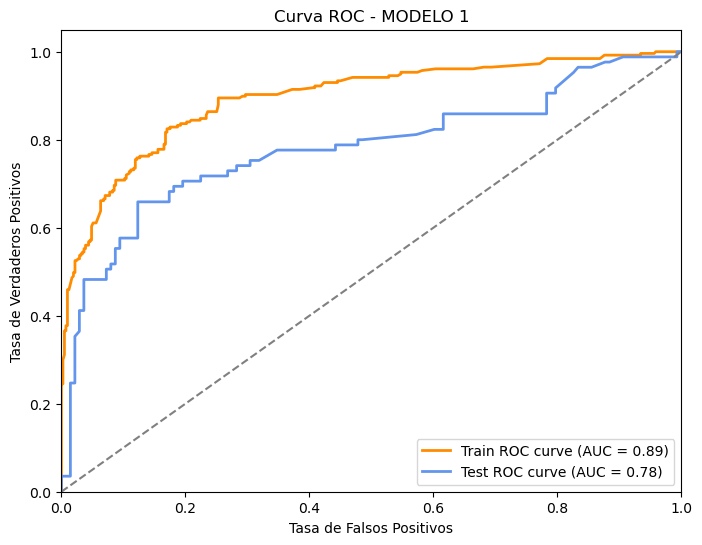

In [57]:
# ROC Y AUC
# Calcula las curvas ROC y el área bajo la curva (AUC) para entrenamiento y prueba
y_train = y_train
y_train_proba = y_pred_prob_train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

y_test = y_test
y_test_proba = y_pred_prob_test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafica las curvas ROC en el mismo gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - MODELO 1')
plt.legend(loc='lower right')
plt.show()

In [58]:
# Metricas
print('TRAIN')
accuracy = round(accuracy_score(y_train, y_pred_train),3)
conf_matrix = confusion_matrix(y_train, y_pred_train)
recall = round(recall_score(y_train, y_pred_train),3)
f1 = round(f1_score(y_train, y_pred_train),3)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print('-----------------------------------------------')
print('-----------------------------------------------')
print('TEST')
accuracy = round(accuracy_score(y_test, y_pred_test),3)
conf_matrix = confusion_matrix(y_test, y_pred_test)
recall = round(recall_score(y_test, y_pred_test),3)
f1 = round(f1_score(y_test, y_pred_test),3)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

TRAIN
Accuracy: 0.831
Recall: 0.763
F1 Score: 0.776
Confusion Matrix:
[[359  52]
 [ 61 196]]
-----------------------------------------------
-----------------------------------------------
TEST
Accuracy: 0.767
Confusion Matrix:
[[113  25]
 [ 27  58]]
Recall: 0.682
F1 Score: 0.69
